<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1e_regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regresión lineal simple

<div style="text-align: right"> Bere et Richardt </div>

---

Para comenzar a familiarizarnos con PyTorch implementaremos un modelo de regresión lineal simple sobre un conjunto de datos de calificaciones, lo que deseamos predecir es que calificación tendrá el alumno en un examen. El conjunto de datos posee dos atributos entrada: la calificación que obtuvo en un examen previo y el número de horas que estudio el alumno para presentar el examen. En este ejemplo nos enfocaremos en realizar regresion lineal simple, por lo tanto, consideraremos únicamente un atributo de entrada, el número de horas de estudio.


## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# sistema de archivos
import os
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as vutils

from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url


# directorio de datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv'
base_dir = '../data/califs/'
filename = 'califs.csv'
filepath = os.path.join(base_dir, 'califs.csv')

# para reproducibilidad
SEED = 0
torch.manual_seed(SEED)

## 2 Datos

Descargamos los datos para el caso de Colab.

In [2]:
download_url(URL, base_dir, filename)

Using downloaded and verified file: ../data/califs/califs.csv


Utilizamos [Pandas](https://pandas.pydata.org/) para la lectura del csv e imprimimos los primeros 5 ejemplos.

In [3]:
df = pd.read_csv(filepath, names=['calif anterior','horas de estudio','calificación'])
df.head(5)

,calif anterior,horas de estudio,calificación
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770


Graficamos los datos para tener una idea más clara de como se encuentran distribuidos.

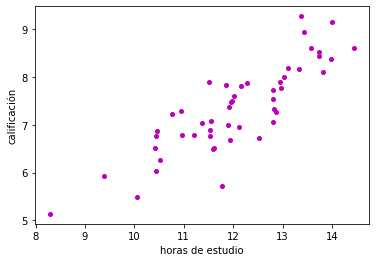

In [4]:
# se obtiene el atributo de entrada y se agrega una dimensión
x_trn = np.array(df.iloc[:,1], dtype="float32")[..., np.newaxis]
# se obtiene la salda
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]
# graficamos
plt.plot(x_trn, y_trn, '.', color='m', markersize=8)
plt.xlabel('horas de estudio')
plt.ylabel('calificación')
plt.show()

### 2.1 Tuberias de datos con PyTorch

<!-- ![data](https://raw.githubusercontent.com/bereml/cap-2021-1/blob/master/figs/dataloader.png) -->

![data](../figs/regresion_lineal_datos.png)

In [5]:
class CalifDS:
    
    def __init__(self, X, Y):
        self.x = X
        self.y = Y

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.y)

### 2.2 Exploración


Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [6]:
# tamaño del lote
batch_size = 16

# creamos un Dataset
ds = CalifDS(x_trn, y_trn)

# creamos un DataLoader
trn_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 1]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


In [7]:
len(ds)

50

### Quiz 1

¿ Cuáles serían las dimensiones si consideraramos los dos atributos de entrada?

## 3 Modelo

### 3.1 Definición de la arquitectura

#### Alto nivel (similar a Keras) 

In [8]:
model = nn.Sequential(
    nn.Linear(1, 1)
)

#### Medio nivel (Chainer, tensorflow.keras.model) 

In [9]:
#se define la clase RegLin que hereda de torch.nn.Module
class RegLin(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super(RegLin, self).__init__()
        # importante: se definen las capas como atributos de la clase
        self.fc = nn.Linear(1, 1)

    # método para inferencia
    def forward(self, x):
        # definición de arquitectura 
        return self.fc(x)

model = RegLin()

#### Bajo nivel

In [10]:
class RegLinBajo(nn.Module):

    def __init__(self, in_features, out_features):
        super(RegLinBajo, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # se envuelven los tensores en parámetros
        # para que model.parameters() los regrese
        # y sean visibles al optimizador
        self.weights = nn.Parameter(torch.zeros(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        y = x @ self.weights + self.bias
        return y
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

# model = RegLinBajo(1, 1)

### 3.2 Modulos y parámetros de PyTorch

Para implementar una arquitectura, PyTorch define las dos siguientes clases:

* `nn.Module` define una red neuronal que internamente puede tener otras redes neuronales anidadas (o capas). Tres metodos importantes son:
  * `__init__(self, args)` es el inicilizador que define al objeto,
  * `fordward(x)` realizar predicción (hacia adelante),
  * `parameters(x)` regresa una lista de los parámetros (`nn.Parameter`) de la red y redes anidadas.


* `nn.Parameter` envuelve un tensor solo para marcarlo como parámetro y que sea regresado por `nn.Module.parameters(x)`.

### Quiz 2

¿Cómo podríamos dibujar la regresión lineal como una red neuronal?

### 3.3 Impresión de la arquitectura

In [11]:
print(model)

RegLin(
  (fc): Linear(in_features=1, out_features=1, bias=True)
)


### 3.4 Prueba de la arquitectura

In [12]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1)
y = model(x)
print(x.dtype)
print(y.shape)
print(y.dtype)

torch.float32
torch.Size([1, 1])
torch.float32


## 4 Entrenamiento

El entrenamiento de un paso del modelo se ilustra con la siguiente figura:

![alt text](../figs/regresion_lineal_entrenamiento.png)


### 4.1 Ciclo de entrenamiento

Realizamos el entrenamiento de nuestro modelo durante dos epocas.

In [13]:
# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)

# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 3
for _ in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        loss_hist.append(loss.item() * 100)

#print(loss_hist)

Graficamos la pérdida para ver el comportamiento durante el entrenamiento.

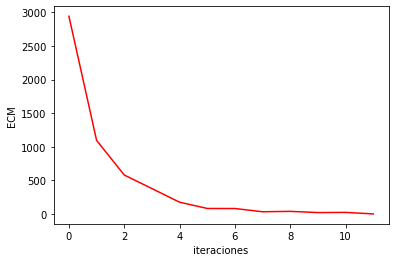

In [14]:
plt.plot(loss_hist, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

Obtenemos los parámetros de nuestro modelo.

In [15]:
[w, b] = model.parameters()

Imprimimos la pendiente:

In [16]:
w

Parameter containing:
tensor([[0.5428]], requires_grad=True)

Imprimimos la ordenada:

In [17]:
b

Parameter containing:
tensor([0.7038], requires_grad=True)

## Inferencia

Graficamos nuestro modelo.

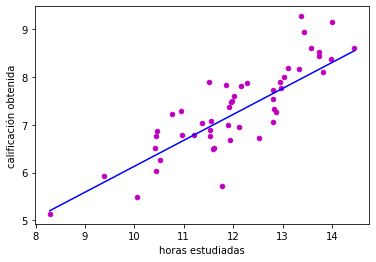

In [18]:
x_train = torch.from_numpy(x_trn)

with torch.no_grad():
    y_pred = model(x_train).numpy()

plt.plot(x_trn, y_trn, '.', color='m', markersize=9)
plt.plot(x_trn, y_pred, color='blue')
plt.xlabel('horas estudiadas')
plt.ylabel('calificación obtenida');

Ahora podemos hacer predicciones con nuestro modelo, por ejemplo, podemos predecir que calificación tendría un alumno si sabemos que estudió durante 12 horas para el examen.

In [19]:
x = torch.tensor([[12.0]])

# deshabilitamos el rastreo de gradientes
with torch.no_grad():
    y_pred = model(x).numpy()

print("La calificación será:", y_pred[0][0])

La calificación será: 7.2174067
